# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [5]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


In [29]:
x_train.shape

(60000, 784)

In [26]:
train_data.shape

AttributeError: ignored

In [109]:
y_train.shape

(60000,)

In [30]:
batch_size

256

In [9]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        print(self.w.shape, self.b.shape)

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Выходной слой
    self.layer_3 = DenseLayer(in_features = n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов
    y = self.layer_1(x)
    y = self.layer_2(y)
    y = self.layer_3(y)
    return tf.nn.softmax(y)

In [8]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    #print(tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred))))
    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    # проверить размерность  y_pred и y_true
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    

In [10]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

dw1 = ""  
dw2 = ""  
dw3 = "" 
db1 = "" 
db2 = ""
db3 = "" 

# Функция обучения нейросети
def train(input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.keras.optimizers.experimental.SGD(learning_rate)
  # Активация автоматического дифференцирования
  with tf.GradientTape() as g1:
    pred = neural_net(input_x) 
    #print(pred.shape)   
    loss = cross_entropy(pred, output_y)        
    global dw1
    global db1
    global dw2
    global db2
    global dw3
    global db3    
    dw1, db1, dw2, db2, dw3, db3 = g1.gradient(loss, [neural_net.layer_1.w, neural_net.layer_1.b, neural_net.layer_2.w, neural_net.layer_2.b, neural_net.layer_3.w, neural_net.layer_3.b])
    optimizer.apply_gradients(zip((dw1, db1, dw2, db2, dw3, db3), [neural_net.layer_1.w, neural_net.layer_1.b, neural_net.layer_2.w, neural_net.layer_2.b, neural_net.layer_3.w, neural_net.layer_3.b]))

(784, 128) (128,)
(128, 256) (256,)
(256, 10) (10,)


In [34]:
#neural_net.layer_3.w

In [90]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1): # Место для вашего кода:
    # Обновляем веса нейронной сети
    # Место для вашего кода
    train(batch_x, batch_y)
    loss = cross_entropy(y_pred=neural_net(batch_x), y_true=batch_y)
    #optimizer.apply_gradients(zip(gradients, [W, b]))
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_history.append(loss.numpy())
        acc_num = accuracy(pred, batch_y)
        accuracy_history.append(acc_num)
        # Место для вашего кода

In [102]:
#loss_history
#accuracy_history

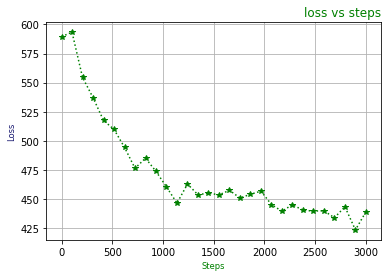

In [100]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
import matplotlib.pyplot as plt
import numpy as np

number_steps =  int(training_steps/display_step)

x = np.linspace(0, training_steps, number_steps)

plt.plot(x, loss_history, label='loss_history', color="green", linestyle='dotted', marker="*")
plt.xlabel('Steps', fontsize='small', color='green')
plt.ylabel('Loss', fontsize='small', color='midnightblue')
plt.title('loss vs steps', fontsize=12, loc="right", color='green')
plt.grid()
# Место для вашего кода

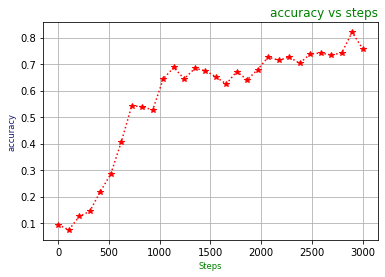

In [101]:
plt.plot(x, accuracy_history, label='loss_history', color="red", linestyle='dotted', marker="*")
plt.xlabel('Steps', fontsize='small', color='green')
plt.ylabel('accuracy', fontsize='small', color='midnightblue')
plt.title('accuracy vs steps', fontsize=12, loc="right", color='green')
plt.grid()

In [29]:
# Вычислите точность обученной нейросети

# Место для вашего кода
precision = tf.keras.metrics.Precision()
y_pred = tf.clip_by_value(neural_net(x_test), 1e-9, 1.)
y_true = tf.one_hot(y_test, depth=num_classes)
precision.update_state(y_pred, y_true)
print(precision.result().numpy())

1.0


[[0.04742425 0.10904733 0.12831116 0.04746878 0.12055613 0.12891248
  0.12891197 0.12027884 0.12159385 0.04749525]
 [0.05807738 0.15550096 0.05909937 0.05807738 0.07864404 0.15787067
  0.1578706  0.15787031 0.05889622 0.05809302]
 [0.04843604 0.06374526 0.13159111 0.04843605 0.13162753 0.13166279
  0.13166276 0.1316358  0.1315587  0.049644  ]
 [0.05458947 0.13429742 0.05459806 0.05458947 0.14741896 0.14838955
  0.14838828 0.14832465 0.05481004 0.0545942 ]
 [0.04946497 0.08956381 0.1340418  0.049465   0.10551412 0.13445972
  0.13444282 0.12005471 0.132582   0.05041109]
 [0.04921223 0.05033978 0.13376136 0.04921231 0.13318643 0.1337727
  0.13377076 0.1337718  0.13375266 0.04921992]
 [0.04729271 0.1105629  0.12847564 0.04729398 0.04875333 0.12855488
  0.12855354 0.12620674 0.10619172 0.12811455]
 [0.04970569 0.11466534 0.13507934 0.04970569 0.08219261 0.13511406
  0.1351112  0.13441354 0.11430681 0.0497057 ]
 [0.05283193 0.10415369 0.12164664 0.05284095 0.05308361 0.14361206
  0.14359482 

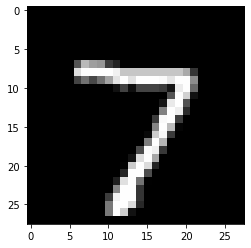

Model prediction:5


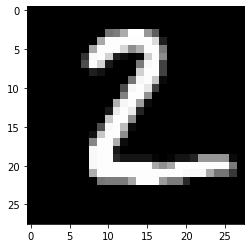

Model prediction:5


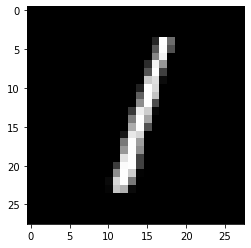

Model prediction:5


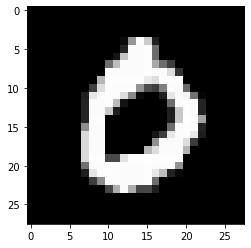

Model prediction:5


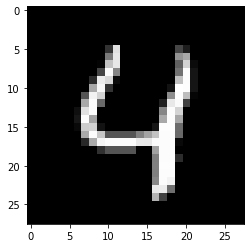

Model prediction:5


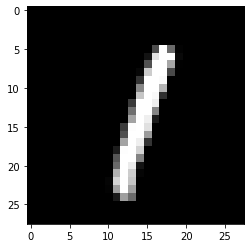

Model prediction:5


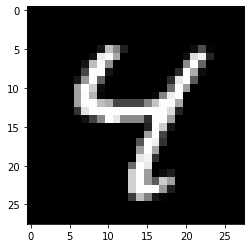

Model prediction:5


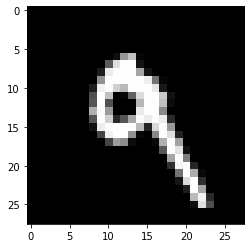

Model prediction:5


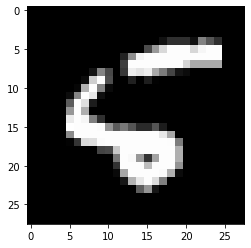

Model prediction:5


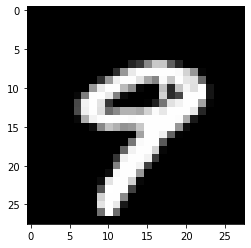

Model prediction:5


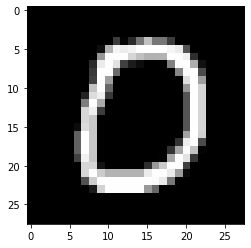

Model prediction:5


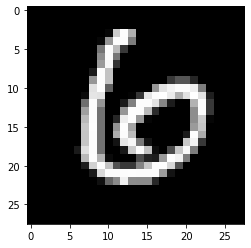

Model prediction:5


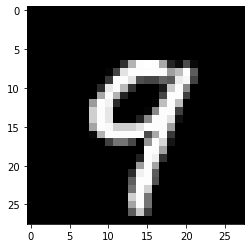

Model prediction:5


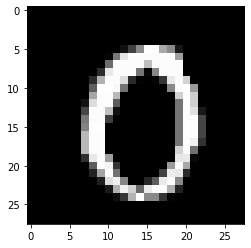

Model prediction:5


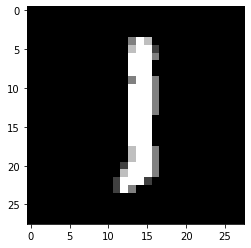

Model prediction:5


In [35]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода

import matplotlib.pyplot as plt
n_images = 15
test_images = x_test[:n_images]
predictions = neural_net(test_images)

# display
print(predictions.numpy())
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i],[28,28]),cmap='gray')
    plt.show()
    print('Model prediction:%i'%np.argmax(predictions.numpy()[i]))
# все время ошибается. В первом выводе вероятность 2, 4, 5, 6 и 7 и 8 очень близки
# во втором выводе вероятность 1, 5, 6 и 7 самы высокие
# нейронная сеть переобучилась и выдает высокую вероятность для 5ти
#Если код запускать с VS code, то все работает адекватно